# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import project_tests as t
import pickle

from sklearn.metrics import accuracy_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [4]:
#missing values
df.isnull().sum(axis=0), df_content.isnull().sum(axis=0)

(article_id     0
 title          0
 email         17
 dtype: int64,
 doc_body           14
 doc_description     3
 doc_full_name       0
 doc_status          0
 article_id          0
 dtype: int64)

In [5]:
#what are the variables
df.shape[0], df["article_id"].unique().shape[0], df["email"].unique().shape[0]

(45993, 714, 5149)

45993 entries : 714 articles read by 5149 users

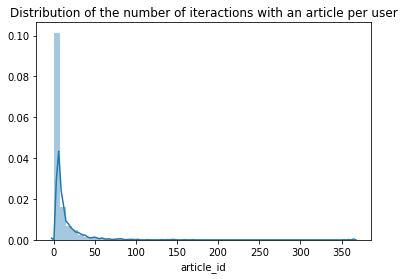

In [6]:
distrib_art_per_user = df.groupby(["email"]).count()["article_id"].reset_index()

sb.distplot(distrib_art_per_user["article_id"])
plt.title("Distribution of the number of iteractions with an article per user");

In [7]:
distrib_art_per_user["article_id"].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

3 users out of 4 have at most 9 interactions with an article.
It is clear than the users with a lot of interactions (up to 364!) with a single article are a skewing the distribution.

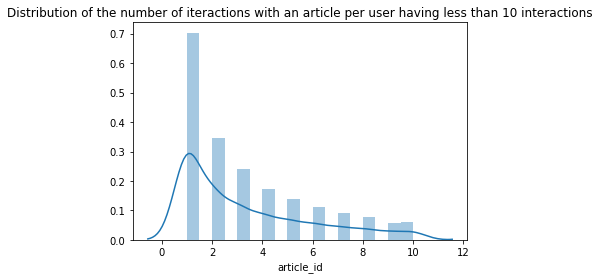

In [8]:
distrib_art_per_user_less_10 = distrib_art_per_user[distrib_art_per_user["article_id"]<=10]
sb.distplot(distrib_art_per_user_less_10["article_id"])
plt.title("Distribution of the number of iteractions with an article per user having less than 10 interactions");

In [9]:
print(distrib_art_per_user_less_10.shape[0])
print(distrib_art_per_user.shape[0])
print(distrib_art_per_user_less_10.shape[0]/distrib_art_per_user.shape[0])

4028
5148
0.7824397824397824


In [10]:
for i in np.arange(1, 11):
    print("Nb of user with {0} interaction(s) with an article in average : {1}".format(i, distrib_art_per_user[distrib_art_per_user["article_id"]==i].shape[0]))

Nb of user with 1 interaction(s) with an article in average : 1416
Nb of user with 2 interaction(s) with an article in average : 694
Nb of user with 3 interaction(s) with an article in average : 485
Nb of user with 4 interaction(s) with an article in average : 351
Nb of user with 5 interaction(s) with an article in average : 277
Nb of user with 6 interaction(s) with an article in average : 228
Nb of user with 7 interaction(s) with an article in average : 182
Nb of user with 8 interaction(s) with an article in average : 156
Nb of user with 9 interaction(s) with an article in average : 115
Nb of user with 10 interaction(s) with an article in average : 124


In [11]:
distrib_art_per_user.describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [12]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [13]:
# Find and explore duplicate articles

In [14]:
df_content.shape[0], df_content["article_id"].unique().shape[0]

(1056, 1051)

Looks like 5 articles have duplicated rows

In [15]:
#what are the duplicated rows
dupl_articles = df_content[df_content.duplicated(subset="article_id")]["article_id"]

df_content[df_content["article_id"].isin(dupl_articles)].sort_values(by="article_id")

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [16]:
# Remove any rows that have the same article_id - only keep the first
df_content_cleaned = df_content.drop_duplicates(subset="article_id")

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
# a.number of unique articles that have an interaction with a user
df["article_id"].unique().shape[0]

714

In [18]:
# b. number of unique articles in the dataset
df_content["article_id"].unique().shape[0]

1051

In [19]:
# c.number of unique users in the dataset (excluding null values)
df["email"].dropna().unique().shape[0]

5148

In [20]:
# d.number of user-article interactions in the dataset
df.shape[0]

45993

In [21]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [23]:
most_viewed_article_id = "1429.0"# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [26]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.title.value_counts().rename_axis("title").reset_index(name="counts")
    top_articles.sort_values(by="counts", ascending=False, inplace=True)
    top_articles.drop_duplicates(subset="title", inplace=True)
    
    return [x for x in top_articles.title][:n] # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.article_id.value_counts().rename_axis("article_id").reset_index(name="counts")
    top_articles.sort_values(by="counts", ascending=False, inplace=True)
    top_articles.drop_duplicates(subset="article_id", inplace=True)
 
    return [str(x) for x in top_articles.article_id][:n] # Return the top article ids

In [27]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [29]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(["user_id", "article_id"])["title"].agg(lambda x: 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [30]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [31]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarities = user_item.dot(user_item.loc[user_id]).reset_index(name="counts")

    # sort by similarity
    similarities.sort_values(by="counts", ascending=False, inplace=True)

    # create list of just the ids
    similarities = list(similarities.user_id)    
   
    # remove the own user's id
    most_similar_users = similarities[1:]
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [32]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [33]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    articles = df[df.article_id.isin(article_ids)].drop_duplicates("article_id")
    article_names = [articles[articles.article_id==float(id)]["title"].values[0] for id in article_ids]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id]>0].index.tolist()
    
    article_names = get_article_names(article_ids)
    
    return [str(id) for id in article_ids], article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    
    recs = []
    seen_articles, _ = get_user_articles(user_id)
    
    for user in similar_users:
        article_ids, article_names = get_user_articles(user)
        
        #article not yet seen nor recommended
        not_seen_articles = list(set(article_ids) - set(seen_articles) - set(recs))
        
        #add them to the recommendations
        recs.extend(not_seen_articles)
        
        #keep the m first articles
        if len(recs) >= m:
            break
    
    return recs[:m-1] # return your recommendations for this user_id   

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['markdown for jupyter notebooks cheatsheet',
 'maximize oil company profits',
 'accelerate your workflow with dsx',
 'a dynamic duo – inside machine learning – medium',
 'higher-order logistic regression for large datasets',
 'improving real-time object detection with yolo',
 'i am not a data scientist – ibm watson data lab',
 'predicting churn with the spss random tree algorithm',
 'flightpredict ii: the sequel  – ibm watson data lab']

In [35]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [36]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    neighbors = user_item.dot(user_item.loc[user_id])

    # sort by similarity and remove the own user's id
    neighbors = neighbors.sort_values(ascending=False).drop(user_id).to_frame(name="counts").reset_index() 
    
    #add the number of interactions of each user with the articles
    user_interactions = df.user_id.value_counts().rename_axis("user_id").reset_index(name="num_interactions")
    
    neighbors_df = neighbors.merge(user_interactions, left_on="user_id", right_on="user_id")
    neighbors_df.rename(columns={"user_id": "neighbor_id", "counts": "similarity"}, inplace=True)
    neighbors_df.sort_values(by=["similarity", "num_interactions"], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #most popular articles
    top_articles = df.article_id.value_counts().rename_axis("article_id").reset_index(name="counts")
    
    #get the similar users
    similar_users = get_top_sorted_users(user_id).neighbor_id.values
    
    recs = []
    seen_articles, _ = get_user_articles(user_id)
    
    for user in similar_users:
        #get the articles read by the similar users
        article_ids, _ = get_user_articles(user)
        
        #article ordered by popularity
        article_ids = top_articles[top_articles.article_id.isin(article_ids)].article_id
        
        #article not yet seen nor recommended
        not_seen_articles = list(set(article_ids) - set(seen_articles) - set(recs))
        
        #add them to the recommendations
        recs.extend(not_seen_articles)
        
        #keep the m first articles
        if len(recs) >= m:
            break
            
    recs = recs[:m-1]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [37]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1024.0, 12.0, 1296.0, 1304.0, 793.0, 555.0, 1324.0, 302.0, 1329.0]

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'timeseries data analysis of iot events by using jupyter notebook', 'fortune 100 companies', 'gosales transactions for logistic regression model', '10 powerful features on watson data platform, no coding necessary', 'build a naive-bayes model with wml & dsx', 'ibm watson facebook posts for 2015', 'accelerate your workflow with dsx', 'ingest data from message hub in a streams flow']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [38]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id[9] # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

If we were given new user, we could not make recommendations based on similar users because we would have no knowledge of the articles the new user might read.

We could instead make recommendations based on the popularity of the articles among more ancient users. Furthermore the new user would probably like to discover the platform so he would rather read the most popular articles first.
The downside of this method is that is may skew our recommendation algorithm later. It puts forward articles the users already have had a lot of interactions with. Next it would put forward articles similar but this similarity might be questionable because it would be based on the same suggestions made for the other users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs_title = get_top_articles(10)


In [41]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [42]:
new_user_recs_title

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [43]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [44]:
import re
import nltk
nltk.download("punkt")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
vectorizer = TfidfVectorizer()

[nltk_data] Downloading package punkt to /home/tipere/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
def tokenize(text):
    """
    Tokenize text into separate words
    Use lemmatizer to break words down into core forms and keep only meaningful words
    
    INPUT : 
    text (str) - text to transform
    
    OUTPUT : 
    clean_token (array, str) - meaningful words of the string
    """
    #normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    #tokenize text
    tokens = word_tokenize(text)
    
    #lematize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

In [46]:
def make_content_recs(data_id, m, user_id=True, df=df):
    '''
    INPUT:
    data_id - (int) id of either user or article
    user_id - (bool) True if data_id=user_id, False if data_id=article_id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
 
    Description:
    Extract the 10 most common words in the title of the articles already read by the user - if it is possible
    Count the number of times these words appear in the other article's title
    The recommendations are the articles whose title contains the most occurences of these words - or the most
    popular article if it is not possible
    
    Notes:
    * By default we give the function a user_id ; we can also give it a article_id but we have to change the 
    user_id=True to user_id=False
    * If new user - ie no article read already - then choose the most popular articles - ie the articles with
    the most interactions
    
    * Choose the articles with the most total common words 
    before choosing those with fewer common words.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    #check whether or not it is a new user by getting already read articles
    if user_id:
        try:
            user_article_id_data, user_title_data = get_user_articles(data_id)
        except KeyError: #user does not exist
            recs = get_top_article_ids(m)
            return(recs, get_article_names(recs))
    else:
        user_title_data = data_id

    #all article's title
    articles_data = df.drop_duplicates("title")[["article_id", "title"]]
    title_data = articles_data.title.tolist()

    #most popular articles
    top_articles = df.article_id.value_counts().rename_axis("article_id").reset_index(name="popularity")

    #articles the user has already read
    user_titles = " ".join(str(x) for x in user_title_data)
    tokenized_user_titles = tokenize(user_titles)

    #article the user has not read yet
    title_not_read = set(title_data) - set(user_title_data)

    #10 most common words
    common_words = pd.DataFrame.from_dict(Counter(tokenized_user_titles), orient="index").reset_index()
    common_words = common_words.rename(columns={"index":"word", 0:"count"})
    common_words = common_words.sort_values("count", ascending=False).head(10)

    #dictionnary with the number of common words per article
    word_count = {}

    #for each title, sum the nummber of occurences of every common word
    for title in title_not_read:
        tok_title = tokenize(title)
        count = sum([tok_title.count(word) for word in common_words.word])
        word_count[title] = count

    word_count = pd.DataFrame.from_dict(word_count, orient="index").reset_index()
    word_count.rename(columns={"index":"title", 0:"word_counts"}, inplace=True)

    #get the article_id
    word_count = word_count.merge(articles_data, left_on="title", right_on="title")

    #get the popularity of each article
    word_count = word_count.merge(top_articles, left_on="article_id", right_on="article_id")

    #order the article by number and common words then by popularity
    word_count.sort_values(by=["word_counts", "popularity"], ascending=False, inplace=True)

    recs = list(word_count.article_id[:m].values.astype(str))
    rec_names = list(word_count.head(m).title)
    
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

This content-based recommendation engine look through all the articles the user has interacted with in order to find the most recurrent word in theses article's title. 
Based on these common words, the engin looks at the number of occurences of theses words in the title of each article.
It then recommend the articles whose title have the most occurences of the common words and who have been the most interacted with.
If a user is new and had no priori interaction with any article then the engine recommends the most popular articles.

One possible improvment could be to use a more descriptive information than just the title - for instance to use a summary or a description of each article - which would add information.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [47]:
df.user_id.max()

5149

In [48]:
# make recommendations for a brand new user
#the user_id 5150 does not exists
make_content_recs("5200", 10)

(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

In [49]:
# make a "recommendations" for a user who only has interacted with article id '1427.0'
make_content_recs(["1427.0"], 10, user_id=False)

(['968.0',
  '60.0',
  '256.0',
  '534.0',
  '588.0',
  '729.0',
  '617.0',
  '422.0',
  '411.0',
  '951.0'],
 ['shiny 0.13.0',
  'readr 1.0.0',
  'xml2 1.0.0',
  'dplyr 0.5.0',
  'tidyr 0.6.0',
  'pixiedust 1.0 is here! – ibm watson data lab',
  'pixiedust gets its first community-driven feature in 1.0.4',
  'brunel 2.0 preview',
  '0 to life-changing app: new apache systemml api on spark shell',
  'shiny 0.12: interactive plots with ggplot2'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [50]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [51]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [52]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In this example we do not have any missing value in the user_item_matrix - which is mandatory to perform SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

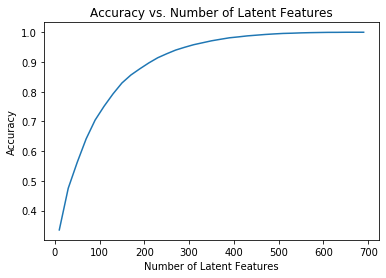

In [53]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [54]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [55]:
#users we can make predictions in the test set : those who are already in the training set
training_idx = user_item_train.index
nb_pred_idx = len(set(training_idx).intersection(test_idx))
print("users we can make prediction for : {}".format(nb_pred_idx))

#users we can not predictions for in the test set : the others
print("users we can not make prediction for : {}".format(len(test_idx)-nb_pred_idx))


#articles we can make predictions in the test set : those who are already in the training set
training_idx = user_item_train.columns
nb_pred_art = len(set(training_idx).intersection(test_arts))
print("users we can make prediction for : {}".format(nb_pred_art))

#users we can not predictions for in the test set : the others
print("users we can not make prediction for : {}".format(len(test_arts)-nb_pred_art))

users we can make prediction for : 20
users we can not make prediction for : 662
users we can make prediction for : 574
users we can not make prediction for : 0


In [56]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [57]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [58]:
#subset of row we can predict
train_common_row = user_item_train.index.isin(user_item_test.index)

test_art = user_item_test.columns
train_common_col = user_item_train.columns.isin(user_item_test.columns)

u_test = u_train[train_common_row, :]
vt_test = vt_train[:, train_common_col]

train_idx = user_item_train.index
sub_user_item_test = user_item_test.loc[test_idx.isin(train_idx)]

u_test.shape, vt_test.shape, sub_user_item_test.shape

((20, 4487), (714, 574), (20, 574))

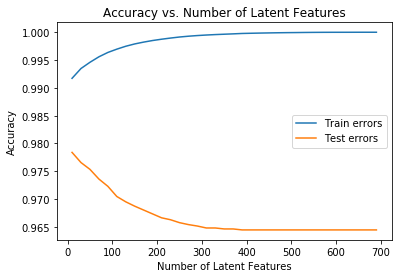

In [59]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
train_errs = []
test_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # total errors and keep track of them
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_pred.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_pred.flatten())) 
    

plt.plot(num_latent_feats, train_errs, label="Train errors")
plt.plot(num_latent_feats, test_errs, label="Test errors")
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Two remarks can be made about this model.  
First the overall accuracy of the model is high because we have a sparse matrix initialy. So few latent features could be necessary to correctly reproduce the original matrix.  
Next we can see that the accuracy curve for the training is the inverse of the curve for the testing. Because of the sparsity of the matrix, we can assume that the more latent features we keep, the more overfitted the model is and the poorer it is at generalizing the results. So if we were to keep that model, we might want to keep few latent features.  
We might improve the model by doing some Cross Validation to determine the best number of latent features.

However I would not use SVD for making recommendations here because the training and testing samples are too small - so we can not assert with certainty the quality of the model.


Still it showed the benefits using training and testing sets with recommendation systems. We might as well duplicate this methodology to the recommendations engine presented earlier in order to evaluate the quality of our recommendations.
From this point we could then compare different engines in order to test how well each recommendation engine is working to further engage users. We could then conduct an A/B test to see the effectiveness of each recommendation engine.

For example, let's say we want to compare the matrix factorization method with the content-based method. We may choose as evaluation metric the number of click on a recommended article - which say whether the user is interested in the article or not.  
Let choose the control group as the group which receives recommendations from the matrix factorization method, and the testing group the group that receives recommendations from the content-based method. We could split the users by cookie-based diversion so that the two groups are of equal size - which by the way would be the invariant metric.  
The null hypothesis would be that there is no significal difference between the number of clicks on the article recommended by each method.  
We would then first check that the invariant metric is invariant - i.e. that the splitting works well.
Then we would look at the evaluation metric for statistical significance. If there is a statistical difference, we might want to deploy the most effective solution - there might be to consider the cost of deployment. Otherwise we might want to keep the solution already implemented or to deploy the solution with the lowest costs.

In [61]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0